In [39]:
from torchvision import transforms, datasets

In [40]:
trans = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

In [41]:
train_dir = r'../data/4weather_classification/train'
test_dir = r'../data/4weather_classification/test'

In [42]:
train_dataset = datasets.ImageFolder(
    train_dir, transform=trans
)
test_dataset = datasets.ImageFolder(
    test_dir, transform=trans
)

In [43]:
train_dataset.class_to_idx

{'cloudy': 0, 'rain': 1, 'shine': 2, 'sunrise': 3}

In [44]:
id_to_class = dict((v, k) for k, v in train_dataset.class_to_idx.items())
id_to_class

{0: 'cloudy', 1: 'rain', 2: 'shine', 3: 'sunrise'}

In [45]:
len(train_dataset), len(test_dataset)

(900, 225)

In [46]:
from torch.utils.data import DataLoader

In [47]:
BATCHSIZE = 16
train_iter = DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True)
test_iter = DataLoader(test_dataset, batch_size=BATCHSIZE)

In [48]:
imgs, labels = next(iter(train_iter))
imgs.shape, labels.shape

(torch.Size([16, 3, 96, 96]), torch.Size([16]))

In [49]:
import matplotlib.pyplot as plt

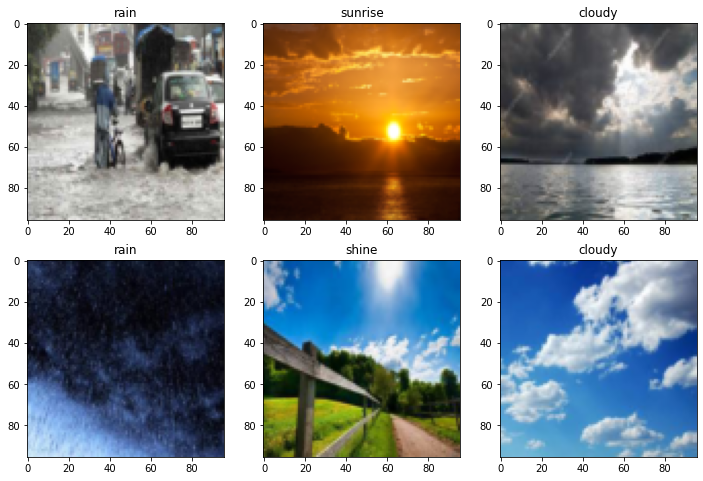

In [50]:
plt.figure(figsize=(12, 8))
for i, (img, label) in enumerate(zip(imgs[:6], labels[:6])):
    img = (img.permute(1, 2, 0).numpy() + 1) / 2
    plt.subplot(2, 3, i + 1)
    plt.title(id_to_class.get(label.item()))
    plt.imshow(img)

In [51]:
import torch
import torchvision
from torch import nn

In [52]:
def fit(epoch, model, train_iter, test_iter, loss, opt, device):

    model.to(device)

    train_correct = 0
    train_total = 0
    train_running_loss = 0

    for x, y in train_iter:
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        opt.zero_grad()
        l = loss(y_hat, y)
        l.backward()
        opt.step()
        with torch.no_grad():
            y_hat = torch.argmax(y_hat, dim=1)
            train_correct += (y_hat == y).sum().item()
            train_total += y.size(0)
            train_running_loss += l.item()
    train_loss = train_running_loss / len(train_iter.dataset)
    train_acc = train_correct / train_total

    test_correct = 0
    test_total = 0
    test_running_loss = 0
    with torch.no_grad():
        for x, y in test_iter:
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            l = loss(y_hat, y)
            y_hat = torch.argmax(y_hat, dim=1)
            test_correct += (y_hat == y).sum().item()
            test_total += y.size(0)
            test_running_loss += l.item()
    test_loss = test_running_loss / len(test_iter.dataset)
    test_acc = test_correct / test_total

    print(
        'epoch: ', epoch,
        'train_loss: ', round(train_loss, 3),
        'train_accura', round(train_acc * 100, 3), '%',
        'test_loss: ', round(test_loss, 3),
        'test_accura', round(test_acc * 100, 3), '%',
    )

    return train_loss, train_acc, test_loss, test_acc

In [53]:
model = torchvision.models.vgg16(pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [54]:
for param in model.features.parameters():
    param.requires_grad = False

In [55]:
model.classifier[-1].out_features = 4

In [56]:
loss = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [57]:
num_epochs = 10

all_train_loss = []
all_train_acc = []
all_test_loss = []
all_test_acc = []

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

for epoch in range(num_epochs):
    train_loss, train_acc, test_loss, test_acc = fit(
        epoch, model, train_iter, test_iter, loss, opt, device
    )
    all_train_loss.append(train_loss)
    all_train_acc.append(train_acc)
    all_test_loss.append(test_loss)
    all_test_acc.append(test_acc)

epoch:  0 train_loss:  0.118 train_accura 80.222 % test_loss:  0.085 test_accura 89.333 %
epoch:  1 train_loss:  0.051 train_accura 92.778 % test_loss:  0.165 test_accura 89.333 %
epoch:  2 train_loss:  0.067 train_accura 93.222 % test_loss:  0.131 test_accura 89.778 %
epoch:  3 train_loss:  0.087 train_accura 94.444 % test_loss:  0.345 test_accura 89.333 %
epoch:  4 train_loss:  0.132 train_accura 94.778 % test_loss:  0.682 test_accura 85.778 %
epoch:  5 train_loss:  0.137 train_accura 95.111 % test_loss:  0.218 test_accura 92.0 %
epoch:  6 train_loss:  0.073 train_accura 97.0 % test_loss:  0.328 test_accura 89.333 %
epoch:  7 train_loss:  0.115 train_accura 96.333 % test_loss:  0.487 test_accura 90.222 %
epoch:  8 train_loss:  0.064 train_accura 97.556 % test_loss:  0.282 test_accura 92.889 %
epoch:  9 train_loss:  0.086 train_accura 96.889 % test_loss:  0.331 test_accura 94.667 %


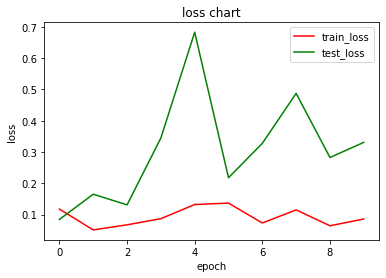

In [58]:
plt.title('loss chart')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(all_train_loss, color='r', label='train_loss')
plt.plot(all_test_loss, color='g', label='test_loss')
plt.legend()

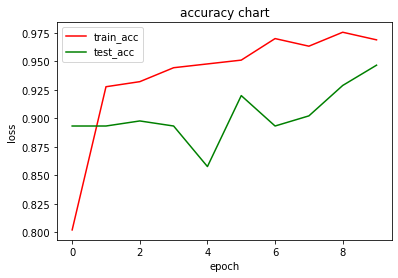

In [59]:
plt.title('accuracy chart')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(all_train_acc, color='r', label='train_acc')
plt.plot(all_test_acc, color='g', label='test_acc')
plt.legend()